# Finding Cu crystal ground state via the Augmented Plane method

This project is adapted from Thijssen and uses data taken from Energy Band Structure of Copper by Glenn A. Burdick.

## Theory

APW is a method for solving the single particle Schrodinger equation in a crystal. It uses the variational principle in the plane wave basis (this is viable due to Bloch's theorem). A basis element for an eigenstate labelled $\vec{k}$ is:

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{1}$$

Due to the size of the potential near the nuclei, the basis set required is too large. APW solves this problem with the Muffin approximation. The equation near the nuclei ($r<R$) is solved exactly and related to the plane waves via boundary conditions at $R$. This allows for the variational method to be applied efficiently. For a full description of the theory see Thijssen. 

## Implementation

The variational equations are not linear, making the problem much harder to solve. In this implementation, a brute force approach has been followed. For a given $\vec{k}$, a list of energies (mesh) over a certain range is defined; the determinant associated with each of these energies is then found. The energy for $\vec{k}$ then corresponds to the energy where the determinant changes sign. This approach is not particularly accurate for the size of the mesh considered but it gives the rough band structure.

This notebook attempts to apply this method to Cu. The data used for the potential near the nuclei is taken from the paper specified above. The implementation is roughly correct though there may be some errors (it is hard to tell as the root finding method used here isn't very accurate).



In [1]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

In [2]:
#constants
a = 6.83087
vol = 3*(a**3)/4

#simulation parameters
l_max = 5
nLim = 2

#recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [3]:
#data for potential

rsAll = np.linspace(0,2,num=10**4)
h = rsAll[1] - rsAll[0]
h2 = h**2
h12 = h2/12

def V(r):
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return -(term1 + term2)/r


In [4]:
#generate A
A = np.empty([len(Ks),len(Ks)])
for i,K_i in enumerate(Ks):
    for j,K_j in enumerate(Ks):
        kDiff = np.linalg.norm(K_i-K_j)
        if kDiff == 0:
            A[i,j] = 1 - 4*np.pi*(rsAll[-2]**3)/(3*vol)
        else:
            A[i,j] = -4*np.pi*(rsAll[-2]**2)*sp.spherical_jn(1,kDiff*rsAll[-2])/(vol*kDiff)

In [5]:
#code for solution to the muffin part

def getRatio(l,E):
    def f(r):
        if r == 0:
            return 0
        return l*(l+1)/r**2 + 2*(V(r) - E) #2 removed
    
    us = np.empty(len(rsAll))
    us[0] = 0
    us[1] = (1-29*rsAll[1]/(l+1))*rsAll[1]**(l+1)

    fn = f(rsAll[1])
    w0 = 0
    w1 = (1 - h12*fn)*us[1]
    
    for n in range(1,len(rsAll)-1):
        w2 = 2*w1 - w0 + h2*us[n]*fn
        fn1 = f(rsAll[n+1])
        us[n+1] = w2/(1 - h12*fn1)
        w0 = w1
        w1 = w2
        fn = fn1

    #returns the required ratio
    uDotEnd = (us[-1] - us[-3])/(2*h)
    return uDotEnd/us[-2] - 1/rsAll[-2] 

In [6]:
def findDet(k,E):
    """
    Finds variational problem determinant.
    """

    #set up k dependent matricies 
    B = np.empty([len(Ks),len(Ks)])
    C = np.empty([len(Ks),len(Ks),l_max])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(len(Ks)):
        for j in range(len(Ks)):
            qDot = np.dot(qs[i],qs[j])
            B[i,j] = A[i,j]*qDot/2
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            for l in range(l_max): 
                C[i,j,l] = (2*l + 1)*2*np.pi*(rsAll[-2]**2)*sp.eval_legendre(l,qDot/(qi*qj))*sp.spherical_jn(l,qi*rsAll[-2])*sp.spherical_jn(l,qj*rsAll[-2])/vol
    
    H = -E*A + B
    for l in range(l_max):
        H += C[:,:,l]*getRatio(l,E)

    #returns +1 if the determinant is positive and -1 if the determinant is negative
    detData = np.linalg.slogdet(H - E*np.identity(len(Ks)))
    sign = detData[0]
    return sign


In [7]:
def findZero(lst,k):
    """
    Given a list, finds the list elements that change sign and a list the k arrays of the same length.
    """
    ks = []
    zeroIndexs = []
    for i in range(1,len(lst)):
        if lst[i-1]*lst[i] == -1:
            ks.append(k)
            zeroIndexs.append(int(i))
    return ks,zeroIndexs

In [8]:
#finds the energies for a list of k's
ks = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
EMesh  = np.arange(0,0.8,step=.01)
kLst = []
indexs = []

for i,k in enumerate(ks):
    print(i)
    detList = [findDet(k,E) for E in EMesh]
    tk,tI =  findZero(detList,k)
    kLst += tk
    indexs += tI

Es = list(map(lambda i: EMesh[i], indexs))

0
1
2
3
4
5
6
7
8
9


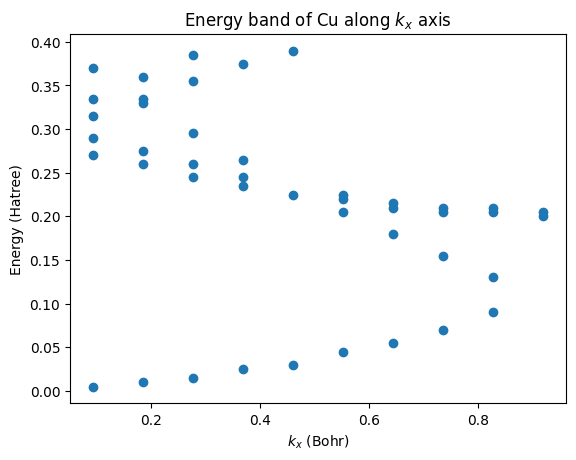

In [9]:
#Graphs 
kx = list(map(lambda k: k[0],kLst))
plt.scatter(kx,np.array(Es)/2)
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()